In [269]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import logging
import datetime
import time
from preprocessing import load_crsp_v2, load_spy_constituents
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [159]:
load_dotenv(".env")
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
mutual_fund_id_path = os.getenv("MUTUAL_FUND_IDENTIFIER_PATH")

### Get SPY identifier in CRSP

In [143]:
mf_df = pd.read_csv(mutual_fund_id_path, encoding = "ISO-8859-1")
mf_df[mf_df['ticker'] == 'SPY']

crsp_fundno  crsp_portno       begdt       enddt    cusip8  \
13570        27635      1004208  2003-07-31  2010-05-31  78462F10   
31499        27635      1021980  2010-06-30  2023-09-30  78462F10   

       crsp_cl_grp               fund_name ticker     ncusip first_offer_dt  \
13570    2008631.0  SPDR S&P 500 ETF Trust    SPY  78462F103     1993-01-22   
31499    2008631.0  SPDR S&P 500 ETF Trust    SPY  78462F103     1993-01-22   

       ... retail_fund inst_fund m_fund index_fund_flag vau_fund et_flag  \
13570  ...           N         Y      N               D        N       F   
31499  ...           N         Y      N               D        N       F   

           end_dt dead_flag delist_cd merge_fundno  
13570  2023-09-29         N       NaN          NaN  
31499  2023-09-29         N       NaN          NaN  

[2 rows x 26 columns]

## Cleaning CRSP Stock_V2 data

In [4]:
data_path = os.getenv("STOCK_DATA_PATH")
data_path

'/Users/sun/Projects/quant/data/crsp_stock_v2_06_16.csv'

In [127]:
raw_df = pd.read_csv(data_path, nrows=100)
raw_df

PERMNO  HdrCUSIP     CUSIP     CUSIP9 PrimaryExch  ShareClass Ticker  \
0    10001  36720410  29274A10  29274A105           Q         NaN   EWST   
1    10001  36720410  29274A10  29274A105           Q         NaN   EWST   
2    10001  36720410  29274A10  29274A105           Q         NaN   EWST   
3    10001  36720410  29274A10  29274A105           Q         NaN   EWST   
4    10001  36720410  29274A10  29274A105           Q         NaN   EWST   
..     ...       ...       ...        ...         ...         ...    ...   
95   10001  36720410  29274A10  29274A105           Q         NaN   EWST   
96   10001  36720410  29274A10  29274A105           Q         NaN   EWST   
97   10001  36720410  29274A10  29274A105           Q         NaN   EWST   
98   10001  36720410  29274A10  29274A105           Q         NaN   EWST   
99   10001  36720410  29274A10  29274A105           Q         NaN   EWST   

   TradingSymbol  PERMCO  NASDCompno  ...  DlyOpen  DlyNumTrd DlyMMCnt  \
0           EWST    7953    60007906  ...     9.70          6       18   
1           EWST    7953    60007906  ...     9.77          6       18   
2           EWST    7953    60007906  ...     9.70         31       18   
3           EWST    7953    60007906  ...     9.50         46       19   
4           EWST    7953    60007906  ...     9.16         29       18   
..           ...     ...         ...  ...      ...        ...      ...   
95          EWST    7953    60007906  ...     9.60          4       17   
96          EWST    7953    60007906  ...      NaN          0       17   
97          EWST    7953    60007906  ...    10.00          3       14   
98          EWST    7953    60007906  ...     9.75         15       17   
99          EWST    7953    60007906  ...     9.66          4       18   

   DlyPrcVol  ShrOut    vwretd    vwretx    ewretd    ewretx    sprtrn  
0     6783.0    2930  0.016406  0.016393  0.010981  0.010940  0.016430  
1     9506.0    2930  0.005523  0.005384  0.007697  0.007588  0.003673  
2    63813.1    2930 -0.000334 -0.000344  0.002920  0.002901  0.000016  
3   115635.9    2930  0.009805  0.009609  0.009032  0.008932  0.009399  
4    42129.2    2930  0.004312  0.004310  0.007009  0.006999  0.003656  
..       ...     ...       ...       ...       ...       ...       ...  
95    9929.9    2932  0.004179  0.004172  0.001897  0.001859  0.004137  
96       0.0    2932 -0.006254 -0.006275 -0.010935 -0.010997 -0.003915  
97    6769.0    2932 -0.003447 -0.003469 -0.000263 -0.000295 -0.004350  
98   39793.2    2932 -0.000251 -0.000286 -0.004145 -0.004206  0.001584  
99    8471.0    2932  0.013911  0.013819  0.012579  0.012553  0.011370  

[100 rows x 48 columns]

In [128]:
raw_df.columns

Index(['PERMNO', 'HdrCUSIP', 'CUSIP', 'CUSIP9', 'PrimaryExch', 'ShareClass',
       'Ticker', 'TradingSymbol', 'PERMCO', 'NASDCompno', 'NASDIssuno',
       'YYYYMMDD', 'DlyCalDt', 'DlyDelFlg', 'DlyPrc', 'DlyPrcFlg', 'DlyCap',
       'DlyCapFlg', 'DlyPrevPrc', 'DlyPrevPrcFlg', 'DlyPrevDt', 'DlyPrevCap',
       'DlyPrevCapFlg', 'DlyRet', 'DlyRetx', 'DlyRetI', 'DlyRetMissFlg',
       'DlyRetDurFlg', 'DlyOrdDivAmt', 'DlyNonOrdDivAmt', 'DlyFacPrc',
       'DlyDistRetFlg', 'DlyVol', 'DlyClose', 'DlyLow', 'DlyHigh', 'DlyBid',
       'DlyAsk', 'DlyOpen', 'DlyNumTrd', 'DlyMMCnt', 'DlyPrcVol', 'ShrOut',
       'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn'],
      dtype='object')

In [129]:
raw_df = pd.read_csv(data_path, nrows=None)

/var/folders/mn/64_gmkvj6j718qjxyr0977d40000gn/T/ipykernel_1553/34301315.py:1: DtypeWarning: Columns (1,2,3,5,26) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(data_path, nrows=None)


In [ ]:
_required_cols = ['PERMNO', 'Ticker', 'DlyCalDt', 'DlyPrc', 'DlyRet']

In [10]:
df = load_crsp_v2(data_path)

/Users/sun/Projects/quant/public/Statistical-Arbitrage-Avellaneda/crsp_preprocess.py:5: DtypeWarning: Columns (1,2,3,5,26) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(path, nrows=nrows) if ".csv" in path else pd.read_parquet(path, nrows=nrows)


In [81]:
df1 = df.groupby('PERMNO').agg({'DlyCalDt': 'count'})
df2 = df1[df1['DlyCalDt'] > 2700]

In [88]:
filtered_permno_set = set(df2.reset_index()['PERMNO'])
len(filtered_permno_set)

3497

In [89]:
filtered_df = df[df['PERMNO'].isin(filtered_permno_set)]
filtered_df

PERMNO Ticker    DlyCalDt  DlyPrc    DlyRet
0          10001   EWST  2006-01-03   9.690 -0.001031
1          10001   EWST  2006-01-04   9.800  0.011352
2          10001   EWST  2006-01-05   9.550 -0.025510
3          10001   EWST  2006-01-06   9.399 -0.015812
4          10001   EWST  2006-01-09   8.920 -0.050963
...          ...    ...         ...     ...       ...
18356109   92807   ASRV  2016-12-23   3.750  0.013514
18356110   92807   ASRV  2016-12-27   3.700 -0.013333
18356111   92807   ASRV  2016-12-28   3.700  0.000000
18356112   92807   ASRV  2016-12-29   3.650 -0.013514
18356113   92807   ASRV  2016-12-30   3.700  0.013699

[9681776 rows x 5 columns]

In [90]:
load_dotenv(".env")
output_dir = os.getenv("DATA_DIR")

In [92]:
filtered_df.to_parquet(output_dir+'/filtered_stock_v2_06_16.parquet')

## Process SPY data

In [48]:
load_dotenv(".env")
spy_path = os.getenv("SPY_HOLDINGS_PATH")

In [68]:
na_values = ['NA', 'N/A', 'NaN', 'null', 'None']
_dtypes = {'permno': pd.Int32Dtype(), 'permco': pd.Int32Dtype()}
spy_raw_df = pd.read_csv(output_dir+'/SPY500_holdings.csv', na_values=na_values, dtype=_dtypes) 

In [69]:
spy_raw_df

crsp_portno   report_dt  security_rank      eff_dt  percent_tna  \
0          1004208  2005-09-30              1  2005-09-30         3.61   
1          1004208  2005-09-30              1  2005-09-30         3.61   
2          1004208  2005-09-30              2  2005-09-30         3.22   
3          1004208  2005-09-30              3  2005-09-30         2.14   
4          1004208  2005-09-30              4  2005-09-30         2.12   
...            ...         ...            ...         ...          ...   
38159      1021980  2016-12-31            502  2017-01-23         0.02   
38160      1021980  2016-12-31            503  2017-01-23         0.01   
38161      1021980  2016-12-31            504  2017-01-23         0.01   
38162      1021980  2016-12-31            505  2017-01-23         0.01   
38163      1021980  2016-12-31            506  2017-01-23         0.01   

       nbr_shares   market_val           security_name     cusip  permno  \
0        26735766         0.00        EXXON MOBIL CORP  30231G10   11850   
1        26735766         0.00        EXXON MOBIL CORP  U3026612    <NA>   
2        44950717         0.00     GENERAL ELECTRIC CO  36960410   12060   
3        39065669         0.00          MICROSOFT CORP  59491810   10107   
4        21915665         0.00           CITIGROUP INC  17296710   70519   
...           ...          ...                     ...       ...     ...   
38159     2350581  38714069.07  ENDO INTERNATIONAL PLC  G3040110   88436   
38160     2204404  33484896.76        PITNEY BOWES INC  72447910   24459   
38161     1002150  28541232.00    URBAN OUTFITTERS INC  91704710   79881   
38162      882757  28327672.13         FIRST SOLAR INC  33643310   91611   
38163     1283519  15145524.20           NEWS CORP NEW  65249B20   13964   

       permco ticker  coupon  maturity_dt  
0       20678    XOM     NaN          NaN  
1        <NA>    NaN     NaN          NaN  
2       20792     GE     NaN          NaN  
3        8048   MSFT     NaN          NaN  
4       20483      C     NaN          NaN  
...       ...    ...     ...          ...  
38159   37931   ENDP     NaN          NaN  
38160   21411    PBI     NaN          NaN  
38161   12546   URBN     NaN          NaN  
38162   51447   FSLR     NaN          NaN  
38163   54433    NWS     NaN          NaN  

[38164 rows x 14 columns]

In [70]:
spy_raw_df.dropna(subset=['permno'], inplace=True)

In [71]:
spy_raw_df

crsp_portno   report_dt  security_rank      eff_dt  percent_tna  \
0          1004208  2005-09-30              1  2005-09-30         3.61   
2          1004208  2005-09-30              2  2005-09-30         3.22   
3          1004208  2005-09-30              3  2005-09-30         2.14   
4          1004208  2005-09-30              4  2005-09-30         2.12   
5          1004208  2005-09-30              4  2005-09-30         1.66   
...            ...         ...            ...         ...          ...   
38159      1021980  2016-12-31            502  2017-01-23         0.02   
38160      1021980  2016-12-31            503  2017-01-23         0.01   
38161      1021980  2016-12-31            504  2017-01-23         0.01   
38162      1021980  2016-12-31            505  2017-01-23         0.01   
38163      1021980  2016-12-31            506  2017-01-23         0.01   

       nbr_shares   market_val           security_name     cusip  permno  \
0        26735766         0.00        EXXON MOBIL CORP  30231G10   11850   
2        44950717         0.00     GENERAL ELECTRIC CO  36960410   12060   
3        39065669         0.00          MICROSOFT CORP  59491810   10107   
4        21915665         0.00           CITIGROUP INC  17296710   70519   
5        31292897         0.00              PFIZER INC  71708110   21936   
...           ...          ...                     ...       ...     ...   
38159     2350581  38714069.07  ENDO INTERNATIONAL PLC  G3040110   88436   
38160     2204404  33484896.76        PITNEY BOWES INC  72447910   24459   
38161     1002150  28541232.00    URBAN OUTFITTERS INC  91704710   79881   
38162      882757  28327672.13         FIRST SOLAR INC  33643310   91611   
38163     1283519  15145524.20           NEWS CORP NEW  65249B20   13964   

       permco ticker  coupon  maturity_dt  
0       20678    XOM     NaN          NaN  
2       20792     GE     NaN          NaN  
3        8048   MSFT     NaN          NaN  
4       20483      C     NaN          NaN  
5       21394    PFE     NaN          NaN  
...       ...    ...     ...          ...  
38159   37931   ENDP     NaN          NaN  
38160   21411    PBI     NaN          NaN  
38161   12546   URBN     NaN          NaN  
38162   51447   FSLR     NaN          NaN  
38163   54433    NWS     NaN          NaN  

[37073 rows x 14 columns]

In [72]:
result = spy_raw_df.groupby('report_dt')['permno'].agg(set).reset_index()

In [73]:
result

report_dt                                             permno
0   2005-09-30  {34817, 20482, 49154, 86021, 79879, 83981, 594...
1   2006-09-30  {34817, 20482, 49154, 86021, 75789, 59408, 348...
2   2010-06-30  {34817, 20482, 49154, 86021, 79879, 83976, 798...
3   2010-07-31  {34817, 20482, 49154, 86021, 79879, 83976, 798...
4   2010-08-31  {34817, 20482, 49154, 86021, 79879, 83976, 798...
..         ...                                                ...
71  2016-07-31  {34817, 20482, 49154, 86021, 79881, 67598, 594...
72  2016-09-30  {34817, 20482, 49154, 86021, 65541, 79881, 675...
73  2016-10-31  {34817, 20482, 49154, 86021, 65541, 79881, 675...
74  2016-11-30  {34817, 20482, 49154, 86021, 65541, 79881, 675...
75  2016-12-31  {34817, 20482, 49154, 65541, 79881, 67598, 594...

[76 rows x 2 columns]

In [76]:
spy_dict = {}
for _, row in result.iterrows():
    spy_dict[row['report_dt']] = row['permno']

In [78]:
import pickle
with open('spy_dict', 'wb') as outfile:
    pickle.dump(spy_dict, outfile)

In [96]:
permco = spy_raw_df.groupby('report_dt')['permco'].agg(set).reset_index()
spy_permco_dict = {}
for _, row in permco.iterrows():
    spy_permco_dict[row['report_dt']] = row['permco']
with open('spy_permco_dict', 'wb') as outfile:
    pickle.dump(spy_permco_dict, outfile)

# 2. PCA method

In [553]:
CORR_WINDOW = 252
RESIDUAL_WINDOW = 60
N_COMPONENTS = 15
DATE_COL = 'DlyCalDt'
RET_COL = 'DlyRet'
ID_COL = 'PERMNO'

In [292]:
from bisect import bisect
spy_change_dates = [s for s in spy_dict.keys()]
asof_date = '2007-05-01'
spy_date_index = min(max(0, bisect(spy_change_dates, asof_date))-1, len(spy_change_dates)-1)
spy_constituents = spy_dict[spy_change_dates[spy_date_index]]

In [488]:
mkt_portfolio = spy_raw_df[spy_raw_df['report_dt'] == spy_change_dates[spy_date_index]].set_index('permno')['percent_tna']

In [601]:
mkt_df = df[(df.PERMNO.isin(spy_constituents)) & (df.DlyCalDt < asof_date)]
trading_days = [d for d in df[DATE_COL].unique()]
trading_days.sort()

In [294]:
asof_dt_index = min(max(0, bisect(trading_days, asof_date))-1, len(trading_days)-1)
mkt_portfolio_start_date = trading_days[max(asof_dt_index-CORR_WINDOW, 0)]
mkt_portfolio_end_date = trading_days[asof_dt_index]
mkt_portfolio_data = df[(df[DATE_COL]> mkt_portfolio_start_date) 
                                & (df[DATE_COL] <= mkt_portfolio_end_date) 
                                & (df[ID_COL].isin(spy_constituents))]
print(f"Building market portfolio during ({mkt_portfolio_start_date}, {mkt_portfolio_end_date}]."
      f"Tracing back {len(mkt_portfolio_data[DATE_COL].unique())} days"
      f"for {len(mkt_portfolio_data[ID_COL].unique())} securities")

Building market portfolio during (2006-04-27, 2007-04-30].Tracing back 252 daysfor 482 securities


In [295]:
mkt_constituents = [sec_id for sec_id in mkt_portfolio_data[ID_COL].unique()]
# mkt_constituents_series = [mkt_portfolio_data[mkt_portfolio_data[ID_COL] == sec_id].set_index(DATE_COL)[RET_COL].sort_index() for sec_id in mkt_constituents]
# std_ret_series = [(ret-ret.mean())/ret.std() for ret in mkt_constituents_series]


In [333]:
ret_table = mkt_portfolio_data.pivot_table(index='DlyCalDt', columns='PERMNO', values='DlyRet')
ret_table

PERMNO         10104     10107     10137     10138     10145     10147  \
DlyCalDt                                                                 
2006-04-28 -0.022773 -0.113761  0.038776 -0.009063 -0.014607 -0.013869   
2006-05-01 -0.000685  0.005797 -0.006736 -0.027675  0.013647 -0.014064   
2006-05-02 -0.010288 -0.011527  0.018649  0.007696  0.015785  0.003754   
2006-05-03 -0.007623 -0.034985 -0.013037 -0.006546 -0.001143  0.000000   
2006-05-04 -0.002095  0.011653 -0.001405  0.006101  0.009380  0.000000   
...              ...       ...       ...       ...       ...       ...   
2007-04-24 -0.006336  0.000347  0.026505  0.004508  0.032598 -0.000645   
2007-04-25  0.004251  0.006947 -0.004058 -0.013659  0.020605  0.015484   
2007-04-26  0.002646  0.003794 -0.006667 -0.010485 -0.005557 -0.010801   
2007-04-27  0.007916  0.035052 -0.011931 -0.003399  0.022351  0.004496   
2007-04-30 -0.015707 -0.005976  0.008679 -0.003410 -0.012935 -0.029412   

PERMNO         10225     10299     10324     10516  ...     90441     90537  \
DlyCalDt                                            ...                       
2006-04-28 -0.005203 -0.003928 -0.000490  0.004145  ...  0.004684  0.007273   
2006-05-01 -0.005604 -0.001972 -0.028450  0.045680  ... -0.003497  0.010514   
2006-05-02  0.009393 -0.002540 -0.011612  0.102632  ...  0.004678  0.039614   
2006-05-03  0.007940  0.010470  0.003065  0.033890  ...  0.009313 -0.020258   
2006-05-04 -0.011571  0.000280 -0.013580 -0.076639  ...  0.018454  0.004923   
...              ...       ...       ...       ...  ...       ...       ...   
2007-04-24 -0.004212  0.020872 -0.006816  0.008984  ... -0.007302  0.008309   
2007-04-25  0.017291  0.006470  0.014974  0.005342  ...  0.009087  0.038900   
2007-04-26 -0.021521  0.000775 -0.006301 -0.012399  ... -0.005146  0.006415   
2007-04-27  0.004124 -0.012648  0.006805 -0.000512  ... -0.015517  0.010547   
2007-04-30 -0.003111 -0.021699  0.003226 -0.007947  ... -0.019702 -0.034178   

PERMNO         90609     90880     91063     91207     91218  91388     91392  \
DlyCalDt                                                                        
2006-04-28 -0.023753 -0.019200 -0.010435  0.008790       NaN    NaN       NaN   
2006-05-01  0.015815 -0.006117 -0.014060 -0.002266       NaN    NaN       NaN   
2006-05-02  0.002395 -0.013131 -0.010441  0.005764       NaN    NaN       NaN   
2006-05-03 -0.025090  0.000624  0.003860  0.024140       NaN    NaN       NaN   
2006-05-04  0.011029  0.003532  0.017944  0.021197       NaN    NaN       NaN   
...              ...       ...       ...       ...       ...    ...       ...   
2007-04-24 -0.018919 -0.011887  0.010643  0.001300 -0.008310    NaN -0.009288   
2007-04-25 -0.015152  0.022556  0.000468 -0.004039  0.004714    NaN  0.015057   
2007-04-26  0.023776  0.001471 -0.005848  0.003621  0.041877    NaN -0.006717   
2007-04-27  0.001366 -0.012563 -0.015765 -0.003897  0.017011    NaN  0.005917   
2007-04-30 -0.004093 -0.017350 -0.013866 -0.028977 -0.015415    NaN -0.030812   

PERMNO         92655  
DlyCalDt              
2006-04-28  0.041675  
2006-05-01  0.001206  
2006-05-02 -0.024498  
2006-05-03 -0.040552  
2006-05-04 -0.001716  
...              ...  
2007-04-24  0.005190  
2007-04-25 -0.023788  
2007-04-26 -0.004345  
2007-04-27  0.008348  
2007-04-30 -0.001693  

[252 rows x 482 columns]

### 2.0 Corr Matrix Analysis

In [386]:
ret_mean = ret_table.mean(axis=0)
ret_stddev = ret_table.std(axis=0)
std_ret = (ret_table - ret_mean) / ret_stddev

In [449]:
corr_matrix = np.corrcoef(std_ret.fillna(0), rowvar=False)

In [538]:
eigenvalues = np.linalg.eigvals(corr_matrix)
eigenvalues.sort()
eigenvalues

array([-3.25418023e-15+0.00000000e+00j, -3.14651058e-15+0.00000000e+00j,
       -2.69381564e-15+0.00000000e+00j, -2.54956200e-15+0.00000000e+00j,
       -2.46467334e-15-2.59086630e-16j, -2.46467334e-15+2.59086630e-16j,
       -2.32378573e-15-6.42519115e-16j, -2.32378573e-15+6.42519115e-16j,
       -2.32137052e-15+0.00000000e+00j, -2.32058932e-15-5.02110800e-16j,
       -2.32058932e-15+5.02110800e-16j, -2.20315559e-15+0.00000000e+00j,
       -2.16829176e-15-3.30946222e-16j, -2.16829176e-15+3.30946222e-16j,
       -2.09878148e-15-6.65509405e-16j, -2.09878148e-15+6.65509405e-16j,
       -2.06437076e-15-2.13203330e-15j, -2.06437076e-15+2.13203330e-15j,
       -1.97116818e-15-1.73506139e-16j, -1.97116818e-15+1.73506139e-16j,
       -1.93073846e-15-3.37219256e-16j, -1.93073846e-15+3.37219256e-16j,
       -1.89293059e-15-4.63246415e-16j, -1.89293059e-15+4.63246415e-16j,
       -1.79505536e-15-9.78001095e-17j, -1.79505536e-15+9.78001095e-17j,
       -1.78388084e-15+0.00000000e+00j, -1.70565357

In [530]:
# corr_pca = PCA(n_components=N_COMPONENTS)
# pca_model = corr_pca.fit(corr_matrix)

In [464]:
# weight = pd.DataFrame(pca_model.components_, columns=ret_table.columns)

PERMNO     10104     10107     10137     10138     10145     10147     10225  \
0      -0.039977 -0.040447 -0.021819 -0.070287 -0.060446 -0.031355 -0.059089   
1      -0.017159 -0.006540  0.006082 -0.015279  0.035095 -0.010893  0.001008   
2      -0.004932  0.008896  0.147411  0.014547 -0.025335 -0.027034 -0.002100   
3       0.048088 -0.024527  0.014259  0.001789 -0.027265  0.074167 -0.032976   
4       0.031425  0.027386  0.063734 -0.010484  0.029290  0.067702 -0.011611   
5       0.041977  0.071566  0.029985  0.028672  0.035316  0.047338 -0.011966   
6      -0.042464 -0.105518  0.050985 -0.036322 -0.032674 -0.056307 -0.036643   
7       0.006589  0.036910 -0.003348  0.033027 -0.026509 -0.017137 -0.040203   
8       0.016965 -0.094467 -0.001611 -0.027190  0.002524  0.002946 -0.038888   
9       0.058131  0.012803 -0.063889  0.071388 -0.020857  0.033164  0.019680   
10     -0.054574 -0.077788  0.070445  0.059912  0.021915 -0.040291  0.037563   
11      0.064361  0.079110 -0.010118  0.027534  0.098569 -0.050243 -0.002632   
12     -0.031880  0.065920  0.014234 -0.075530 -0.009411 -0.024031 -0.060616   
13     -0.037265 -0.101084  0.022267 -0.004227  0.008028 -0.040180 -0.077857   
14     -0.041784 -0.055525 -0.009994 -0.011384  0.047907 -0.028254  0.039972   

PERMNO     10299     10324     10516  ...     90441     90537     90609  \
0      -0.045324 -0.034245 -0.019052  ... -0.046406 -0.011319 -0.007256   
1      -0.011194 -0.018905  0.075822  ...  0.013201  0.153966  0.024777   
2      -0.072911 -0.011412  0.034411  ...  0.021163  0.030937 -0.014667   
3       0.149075  0.038899 -0.011683  ... -0.024047  0.000479 -0.014675   
4       0.031194 -0.019624 -0.000318  ... -0.007302 -0.007520  0.050284   
5       0.001989  0.059296 -0.028027  ...  0.011295  0.025110  0.038224   
6       0.035977 -0.020128 -0.020095  ... -0.063117  0.025610 -0.018494   
7      -0.042533 -0.016316 -0.025193  ...  0.042627  0.005349  0.001157   
8      -0.025793 -0.033381  0.017492  ...  0.002636 -0.026191 -0.012793   
9      -0.063264  0.027729 -0.014549  ...  0.035499 -0.009825  0.010764   
10      0.118701 -0.008949  0.032308  ... -0.029145 -0.024722 -0.074066   
11      0.052550 -0.059645  0.001267  ... -0.039337 -0.015746  0.086043   
12      0.002343 -0.010848  0.007925  ... -0.009528 -0.029632  0.078943   
13     -0.116436 -0.044929  0.032684  ...  0.023285 -0.005907 -0.001017   
14     -0.008420 -0.022213  0.064616  ...  0.044164 -0.023704  0.038291   

PERMNO     90880     91063     91207     91218     91388     91392     92655  
0      -0.062419 -0.045144 -0.061970 -0.018852 -0.008082 -0.022156 -0.014292  
1       0.019394 -0.036881  0.008671 -0.006089 -0.010332 -0.003066 -0.017080  
2       0.010723  0.011195 -0.020979  0.005306 -0.007869  0.031392  0.024821  
3       0.051584 -0.033107 -0.021302  0.038860  0.002367 -0.016130 -0.055128  
4      -0.046031 -0.003191  0.036319 -0.016230  0.015770  0.032693 -0.071892  
5       0.034257  0.021357 -0.011540  0.054665 -0.023357 -0.032349  0.162081  
6      -0.017474 -0.022396  0.016363  0.000062  0.022456 -0.013698  0.036109  
7       0.045326 -0.001924  0.095988  0.055727 -0.020698  0.002340  0.047501  
8      -0.002751 -0.032772  0.109522 -0.067271 -0.027854 -0.020083  0.091821  
9       0.030834 -0.017472 -0.006269 -0.033664 -0.063193 -0.015412 -0.114709  
10     -0.013523  0.002804 -0.048863 -0.021010  0.033360 -0.042720  0.038384  
11      0.039151  0.004362 -0.047583  0.057882 -0.051564  0.007710 -0.005469  
12      0.026375 -0.076826 -0.015243  0.106674 -0.025645 -0.032873 -0.049959  
13     -0.008733  0.020036  0.059711  0.005388 -0.017668 -0.071026 -0.017444  
14     -0.000456  0.022066 -0.013290  0.048151  0.045006  0.034653 -0.059612  

[15 rows x 482 columns]

### 2.1 PCA factorize

/Users/sun/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/sun/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sun/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


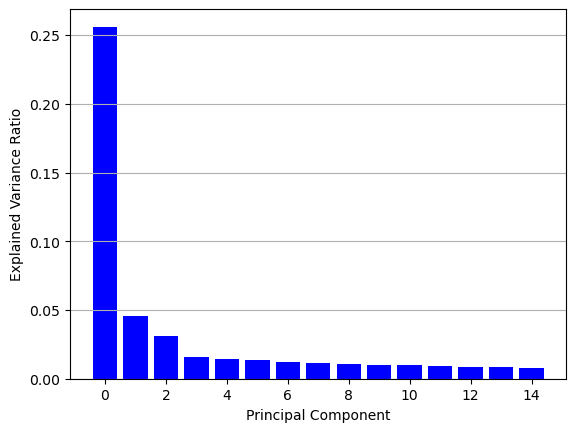

In [540]:
# PCA 
ret_table.fillna(0, inplace=True)
ret_mean = ret_table.mean(axis=0)
ret_stddev = ret_table.std(axis=0)
std_ret = (ret_table - ret_mean) / ret_stddev

pca_model = PCA(n_components=N_COMPONENTS).fit(std_ret)
# pca
# Portfolio built on May 1, 2017. Explained Variance Plot.
x_values = np.arange(len(pca_model.explained_variance_ratio_))
plt.bar(x_values, pca_model.explained_variance_ratio_, color='blue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(axis='y')

In [543]:
pca_model.components_

array([[-0.03967341, -0.03755244, -0.04114727, ..., -0.01234106,
        -0.02719604, -0.02460019],
       [ 0.02364221,  0.01430988, -0.00965001, ...,  0.01033132,
         0.00525893,  0.01518621],
       [ 0.00532766, -0.00514592, -0.14579408, ...,  0.00637382,
        -0.02931837, -0.02942901],
       ...,
       [-0.02853363,  0.06818647,  0.01302956, ..., -0.02491947,
        -0.02667263, -0.05512403],
       [-0.03757314, -0.09643958,  0.02319718, ..., -0.02092753,
        -0.0768868 , -0.01314722],
       [-0.04240546, -0.05625997, -0.01022614, ...,  0.04115672,
         0.03160979, -0.0587395 ]])

In [545]:
loadings = pd.DataFrame(pca_model.components_, columns=std_ret.columns)
weights = loadings / ret_stddev
factor_ret = pd.DataFrame(np.dot(ret_table, weights.transpose()), index=ret_table.index)
# factor_ret.columns = ['component_'+str(i) for i in range(N_COMPONENTS)]
factor_ret

0          1         2         3          4          5   \
DlyCalDt                                                                     
2006-04-28  -1.367832  -1.733735 -7.739585  0.621456 -10.514605   0.411951   
2006-05-01   8.438536 -10.180798  5.405886 -4.843502   3.753530  -2.479738   
2006-05-02  -8.743764  -6.931167 -4.792706 -1.056106   1.704980   1.853670   
2006-05-03   2.006593   2.036522  6.745681  2.017685   1.856703  10.258742   
2006-05-04  -7.235997   3.112840  0.681725 -0.694207   3.446486   2.293037   
...               ...        ...       ...       ...        ...        ...   
2007-04-24  -0.147598   0.765083 -0.570036  7.946520   3.132054  -5.043921   
2007-04-25 -15.683081  -2.847025 -3.523045  0.971086  -2.513350   5.315615   
2007-04-26   1.776938  -0.169652  6.763088  2.525914  -4.548158  -1.147513   
2007-04-27   1.934879  -1.267142  3.416400 -2.475359  -0.920890   2.245992   
2007-04-30  15.965299   1.237223 -0.295719  1.546838  -2.178628  -2.359462   

                  6         7         8         9         10        11  \
DlyCalDt                                                                 
2006-04-28 -4.376363 -0.788728 -7.168270 -5.304223  3.260138  5.928860   
2006-05-01  2.091326 -2.089395  0.845842  2.350297  0.198763 -1.259026   
2006-05-02  1.426771 -5.869840 -4.295728 -1.363454  2.977840 -2.289370   
2006-05-03 -0.408312 -1.917548  2.361720  3.766248  1.613816  3.307295   
2006-05-04  2.287093  4.051959 -2.673954  0.526315  2.237660  1.823780   
...              ...       ...       ...       ...       ...       ...   
2007-04-24 -4.755086 -4.242551 -1.939975 -4.801001  6.086194  0.979167   
2007-04-25  1.128712 -8.368287 -2.364920 -0.054012 -4.721287  0.775250   
2007-04-26 -5.545623  4.609981 -0.369615 -3.873223 -8.903373 -3.233415   
2007-04-27  4.665579  1.459435 -0.582201  0.375574 -0.068801 -1.810315   
2007-04-30  3.110819 -2.533233 -0.644353 -0.452817  1.106064  0.962606   

                  12        13         14  
DlyCalDt                                   
2006-04-28 -5.127627  8.691505  -0.188259  
2006-05-01  3.799229  0.254722   0.221003  
2006-05-02 -3.594475  0.642138   4.622163  
2006-05-03  0.510160  3.317041  -0.654887  
2006-05-04 -0.909556  0.073919  -0.912971  
...              ...       ...        ...  
2007-04-24 -1.605643  3.754942   0.479483  
2007-04-25  3.487812 -2.540143   3.328928  
2007-04-26  7.235902 -3.353823  13.001816  
2007-04-27 -3.590459  0.478033   0.098507  
2007-04-30 -1.212167  0.851711   2.111245  

[252 rows x 15 columns]

In [551]:
principal_ret = factor_ret.iloc[:,0]

In [547]:
mkt_portfolio_ret = ret_table @ (mkt_portfolio)

In [552]:
principal_ret.corr(mkt_portfolio_ret)

-0.9827802361401122

### 2.2 Residuals

In [570]:
window_start = trading_days[max(asof_dt_index-RESIDUAL_WINDOW, 0)]
window_end = trading_days[max(asof_dt_index, 0)]
ret_records = df[(df[DATE_COL] > window_start) 
                 & (df[DATE_COL] <= window_end)]

In [562]:
ret_records

PERMNO Ticker    DlyCalDt   DlyPrc    DlyRet
272        10001   EWST  2007-02-02  11.2000 -0.017544
273        10001   EWST  2007-02-05  11.4599  0.023205
274        10001   EWST  2007-02-06  11.3900 -0.006100
275        10001   EWST  2007-02-07  11.4000  0.000878
276        10001   EWST  2007-02-08  11.3000 -0.008772
...          ...    ...         ...      ...       ...
18780417   93105    WHI  2007-04-24   4.8400 -0.014257
18780418   93105    WHI  2007-04-25   4.8700  0.006198
18780419   93105    WHI  2007-04-26   4.8500 -0.000856
18780420   93105    WHI  2007-04-27   4.8700  0.004124
18780421   93105    WHI  2007-04-30   4.8400 -0.006160

[422599 rows x 5 columns]

In [569]:
actively_traded = ret_records.groupby('PERMNO').agg({'Ticker': 'count'}).reset_index()
actively_traded_names = set(actively_traded[actively_traded['Ticker'] >= 0.9*RESIDUAL_WINDOW]['PERMNO'])
_ret = ret_records[ret_records[ID_COL].isin(actively_traded_names)].pivot_table(
    index='DlyCalDt', columns='PERMNO', values='DlyRet')
_ret

PERMNO         10001     10002     10025     10026     10028     10032  \
DlyCalDt                                                                 
2007-02-02 -0.017544  0.055825  0.012527 -0.014193 -0.014925  0.025504   
2007-02-05  0.023205  0.018851 -0.014326  0.005368 -0.007614 -0.004049   
2007-02-06 -0.006100  0.028881 -0.020480  0.003641 -0.019047  0.000000   
2007-02-07  0.000878  0.000000  0.027653  0.003144  0.027237  0.026713   
2007-02-08 -0.008772 -0.005702  0.026034 -0.003857  0.000000  0.001697   
2007-02-09  0.014159 -0.018968 -0.025373 -0.009439 -0.015152 -0.007905   
2007-02-12 -0.020070  0.003597  0.023737  0.004886 -0.015385  0.002277   
2007-02-13  0.018700  0.010753  0.002458  0.008023  0.003906 -0.012493   
2007-02-14  0.079646 -0.016844 -0.013643 -0.001206 -0.007782 -0.031052   
2007-02-15  0.007377 -0.013526  0.004755 -0.003864 -0.011765  0.009496   
2007-02-16  0.029292  0.039762  0.003657  0.012606  0.011905 -0.000588   
2007-02-20  0.009486  0.029011  0.029790 -0.007422 -0.031373  0.026471   
2007-02-21  0.041504 -0.016232 -0.003330 -0.020984  0.068826 -0.012607   
2007-02-22  0.000000  0.013461 -0.013573  0.020941 -0.018939 -0.001161   
2007-02-23  0.024060 -0.010711 -0.020957 -0.024855  0.050193 -0.000581   
2007-02-26  0.027900 -0.006496 -0.010811 -0.009899  0.014706  0.006395   
2007-02-27  0.003571 -0.053618 -0.038251 -0.063484 -0.094203 -0.038128   
2007-02-28  0.009964  0.022110  0.030000  0.059247  0.027600 -0.015015   
2007-03-01  0.000000 -0.023434 -0.026037 -0.021416  0.019852  0.009756   
2007-03-02  0.000705 -0.037379 -0.026280 -0.023429 -0.045802 -0.020531   
2007-03-05 -0.027465 -0.025407  0.000931  0.001318 -0.040000 -0.018496   
2007-03-06  0.011593  0.061977 -0.006276  0.028699  0.000000  0.006910   
2007-03-07  0.027194 -0.032422  0.016608 -0.013565 -0.008333  0.006862   
2007-03-08  0.010453 -0.044040  0.054073 -0.013492  0.239496 -0.004337   
2007-03-09  0.004138  0.021532  0.022702  0.000526  0.000000  0.003111   
2007-03-12 -0.014423  0.040686 -0.014088  0.002366 -0.030508  0.015509   
2007-03-13  0.014634 -0.048516 -0.008227 -0.011146 -0.080420 -0.022602   
2007-03-14 -0.000529  0.008911  0.002183  0.028177 -0.001673  0.015000   
2007-03-15 -0.000295  0.041481  0.000871 -0.002068  0.005484  0.004310   
2007-03-16  0.003574  0.005690 -0.043743 -0.008290 -0.045455 -0.009810   
2007-03-19 -0.013699  0.008958  0.011834  0.004702  0.023810  0.013622   
2007-03-20  0.024306  0.019159 -0.006073  0.014301  0.003876  0.017715   
2007-03-21 -0.014237  0.038056 -0.002263  0.003332  0.027027  0.017407   
2007-03-22  0.022696 -0.002208  0.027444  0.015585 -0.048872 -0.001180   
2007-03-23 -0.018157 -0.000885  0.002649 -0.019119  0.007905 -0.010632   
2007-03-26  0.010274  0.000000 -0.007486 -0.002308 -0.031373  0.007761   
2007-03-27 -0.006495 -0.007532 -0.016859 -0.001542  0.000000  0.001777   
2007-03-28 -0.029507 -0.025000 -0.006995 -0.011586  0.020243  0.005322   
2007-03-29 -0.016299 -0.022436 -0.024994  0.013285 -0.023810 -0.004706   
2007-03-30  0.034310 -0.008899  0.002097  0.015167 -0.012195  0.013593   
2007-04-02  0.006220  0.008979  0.024884 -0.000253  0.016461  0.004665   
2007-04-03  0.002067  0.052459  0.009984  0.015957  0.178138  0.017411   
2007-04-04 -0.002748 -0.012906 -0.025612 -0.023186 -0.099656 -0.011409   
2007-04-05 -0.044674  0.004058  0.007840  0.005870  0.049618  0.054818   
2007-04-09  0.012950 -0.048047 -0.027682 -0.004314 -0.050909 -0.008753   
2007-04-10  0.003906 -0.015094  0.002353  0.001274 -0.011494  0.002208   
2007-04-11 -0.008843 -0.010536 -0.005164 -0.013489 -0.003023 -0.008260   
2007-04-12 -0.000714  0.016457  0.005663  0.014190  0.030246  0.014436   
2007-04-13  0.013571 -0.011905  0.028390  0.012211 -0.018868 -0.002189   
2007-04-16 -0.001762  0.010602  0.010495  0.028399 -0.030769  0.025782   
2007-04-17 -0.003883  0.002384 -0.019869 -0.028592 -0.023810  0.000535   
2007-04-18 -0.012757 -0.010466  0.001613 -0.004780  0.020325  0.003741   
2007

In [578]:
from sklearn.linear_model import LinearRegression

residual = pd.DataFrame(columns = _ret.columns, index = _ret.index)
beta = pd.DataFrame(columns = _ret.columns, index = range(15))
window_factor_ret = factor_ret[(factor_ret.index > window_start) & 
                               (factor_ret.index <= window_end)]
ols = LinearRegression()
for sec_id in _ret.columns:
    ols.fit(window_factor_ret, _ret[sec_id].fillna(0))
    beta[sec_id] = ols.coef_
    residual[sec_id] = _ret[sec_id]-ols.intercept_-np.dot(window_factor_ret, ols.coef_)

/Users/sun/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/sun/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/sun/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/sun/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

In [582]:
k = 8.4
cum_res = residual.cumsum()
m = pd.Series(index = cum_res.columns)
sigma_eq = pd.Series(index = cum_res.columns)
for i in cum_res.columns:
    b = cum_res[i].autocorr()
    if -np.log(b) * 252 > k:
        temp = (cum_res[i]-cum_res[i].shift(1)* b)[1:]
        a = temp.mean()
        cosi =temp - a
        m[i] = a/(1-b)
        sigma_eq[i]=np.sqrt(cosi.var()/(1-b*b))
m.dropna(inplace=True)
m = m - m.mean()
sigma_eq.dropna(inplace=True)
s_score = -m/sigma_eq

In [592]:
long_position=s_score[s_score>1.25].reset_index()[ID_COL]
short_position=s_score[s_score<-1.25].reset_index()[ID_COL]

In [603]:
# close_date = trading_days[asof_dt_index+1]
# close_ret = df[(df[DATE_COL] == close_date) & (df[ID_COL].isin(actively_traded_names))]
# close_ret

PERMNO Ticker    DlyCalDt  DlyPrc    DlyRet
332        10001   EWST  2007-05-01   14.41 -0.006892
3101       10002   BTFG  2007-05-01   19.69 -0.016975
4895       10025   AEPI  2007-05-01   41.85 -0.016682
7664       10026   JJSF  2007-05-01   39.96  0.025404
10433      10028   DGSE  2007-05-01    2.39 -0.004167
...          ...    ...         ...     ...       ...
18196253   92690    UMH  2007-05-01   15.19  0.009302
18353677   92807   ASRV  2007-05-01    4.70  0.019523
18463392   92874   VIDE  2007-05-01    8.00 -0.022005
18556301   92930   VOLV  2007-05-01   97.24 -0.000308
18780422   93105    WHI  2007-05-01    4.86  0.004132

[6760 rows x 5 columns]